# Analyse Order 2 order 1

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : May 30th  2022
- last update : 


### 

    


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

from astropy import units as u

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

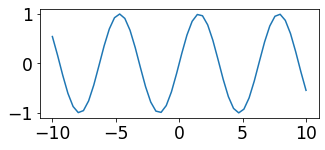

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-06-02'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.8.4'

In [11]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA,HEPSILON,O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [12]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [13]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [14]:
from time import sleep

In [15]:
from astropy.time import Time
import astropy.units as u

In [16]:
DCCD   = 181.45 # mm
#DCCD   = 200.0 # mm
PIXELW = 0.01   # mm (10 microns)

In [17]:
def Dispersion(wl,neff,D):
    """ 
    Dispersion(wl,a,D) : number of dx per wavelength
    input arguments:
    - wl : wavelength in mm
    - neff  : number of lines per mm
    - D  : Distance CCD-Hologram per mm
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx, x in mm and lambdas in mm
    """
    X=D*neff*wl/np.sqrt(1-(wl*neff)**2)
    return X


In [18]:
def Dispersion_Rate(wl,neff,D):
    """
    Dispersion_Rate(wl) : number of dx per wavelength
    input arguments:
    - wl : wavelength in mm
    - neff  : nb lines per mm 
    - D  : Distance CCD-Hologram in mm
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx/dlambda, x in mm and lambdas in mm
    
    """
    dxdlambda=D*neff*(np.sqrt(1-(wl*neff)**2)+ (wl*neff)**2)/(1-(wl*neff)**2)
    #dxdlambda=D*neff/(np.sqrt(1-(wl*neff)**2))**3
    return dxdlambda 

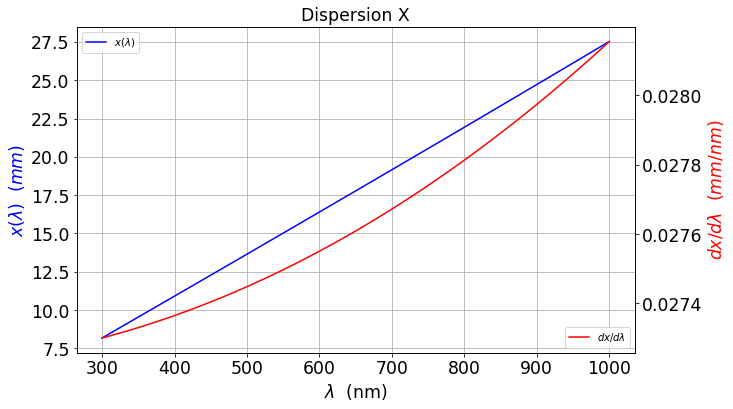

In [19]:
fig, ax1 = plt.subplots(figsize=(10,6))
WL=np.linspace(300.,1000.,100)
neff=150. # lines per mm
D=184.45 # mm

Y1=Dispersion(WL*1e-6,neff,DCCD)
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  ($mm$)",color="blue")
ax1.set_title("Dispersion X")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*1e-6,neff,DCCD)*1e-6 ## mm per nm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($mm/ nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()


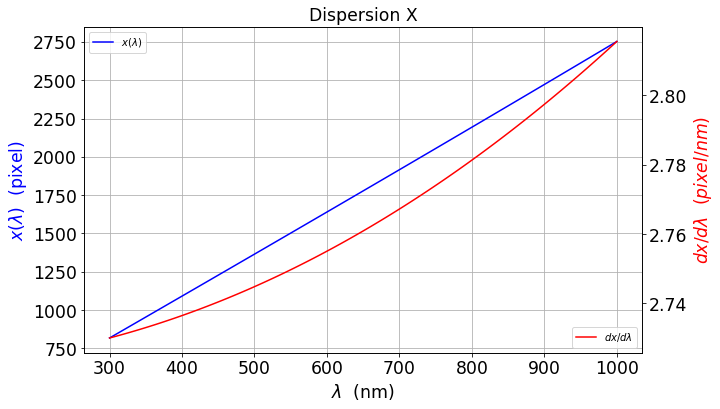

In [20]:
fig, ax1 = plt.subplots(figsize=(10,6))

Y1=Dispersion(WL*1e-6,neff,DCCD)/PIXELW   # pixel
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  (pixel)",color="blue")
ax1.set_title("Dispersion X")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*1e-6,neff,DCCD)/PIXELW*1e-6   # pixel per nm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($pixel/nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()
fig.savefig("DispersionFormula_pixel.pdf")


# Function

In [21]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [22]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [23]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [24]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

- spectrum need config

In [25]:
load_config("../runspectractor_standalone/2022_05/config/auxtel_config_holo_DECONVOLUTION_PSF1D.ini")

No rebinning: parameters.REBIN is forced to 1.


In [26]:
# path index for each month
DATE="20211104"

# Input file

/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400508/basespec

In [27]:
top_path = "/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D"

In [28]:
exposure ="2021110400508"

In [29]:
path=os.path.join(os.path.join(top_path,DATE),exposure)

In [30]:
path_subdir=os.path.join(path,"basespec")

In [31]:
all_files = sorted(os.listdir(path_subdir))

In [32]:
all_files 

['exposure_2021110400508_postisrccd_lines.csv',
 'exposure_2021110400508_postisrccd_spectrogram.fits',
 'exposure_2021110400508_postisrccd_spectrum.fits',
 'exposure_2021110400508_postisrccd_table.csv']

# Read

## Read table

In [37]:
table = pd.read_csv(os.path.join(path_subdir,all_files[-1]))

In [38]:
table

,lambdas,Dx,Dy,Dy_disp_axis,flux_sum,flux_integral,flux_err,fwhm,Dy_fwhm_sup,Dy_fwhm_inf,amplitude,x_c,y_c,gamma,alpha,saturation
0,315.901504,888.059311,-4.992294,-4.339911,12.579628,2.066327,11.109819,29.602921,9.808989,-19.793578,2.066327,0.596516,189.504359,41.764615,5.858908,8500.0
1,316.257136,889.059299,-4.973983,-4.344798,16.719022,2.101339,11.101452,29.578271,9.814976,-19.762942,2.101339,1.596504,189.522670,41.676708,5.843938,8500.0
2,316.612763,890.059287,-4.955685,-4.349685,14.191771,2.461802,11.114247,29.557499,9.822888,-19.734259,2.461802,2.596492,189.540968,41.588972,5.828998,8500.0
3,316.968385,891.059275,-4.937401,-4.354572,21.380217,2.950289,11.130280,29.533910,9.829378,-19.704179,2.950289,3.596480,189.559252,41.501409,5.814090,8500.0
4,317.324002,892.059263,-4.919129,-4.359459,23.035364,3.021663,11.135459,29.513191,9.837290,-19.675548,3.021663,4.596468,189.577524,41.414017,5.799212,8500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,1035.146868,2943.034772,4.906154,-14.382496,3126.276431,2232.766246,15.881831,58.959784,34.385694,-24.573386,2232.766246,2055.571977,199.402807,224.030903,40.377482,8500.0
2056,1035.489480,2944.034760,4.897463,-14.387383,3094.502400,2206.172860,15.853401,58.993514,34.393868,-24.598942,2206.172860,2056.571965,199.394116,224.296370,40.426078,8500.0
2057,1035.832083,2945.034748,4.888760,-14.392270,3103.928383,2227.332660,15.865780,59.027847,34.402331,-24.624812,2227.332660,2057.571953,199.385413,224.562010,40.474705,8500.0
2058,1036.174677,2946.034736,4.880043,-14.397157,3077.516221,2212.193432,15.814428,59.061691,34.410536,-24.650450,2212.193432,2058.571941,199.376696,224.827821,40.523363,8500.0


## Read Spectrum

In [40]:
spectrum = Spectrum(file_name=os.path.join(path_subdir,all_files[2]))

set date_obs to 2021-11-05T04:49:33.916
set expo to 20.0
set airmass to 1.41214447333932
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -66.0397222222222
set hour_angle to -45.38165160354449
set temperature to 5.6
set pressure to 740.35
set humidity to 37.0
set lambda_ref to 572.0006264477072
set parallactic_angle to -60.35656136093252


/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


target_name = etador, Selected object name for Simbad : ETA1 DOR
  MAIN_ID         RA           DEC      ...  Z_VALUE  SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                           
----------- ------------- ------------- ... --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ... 0.0000590                1


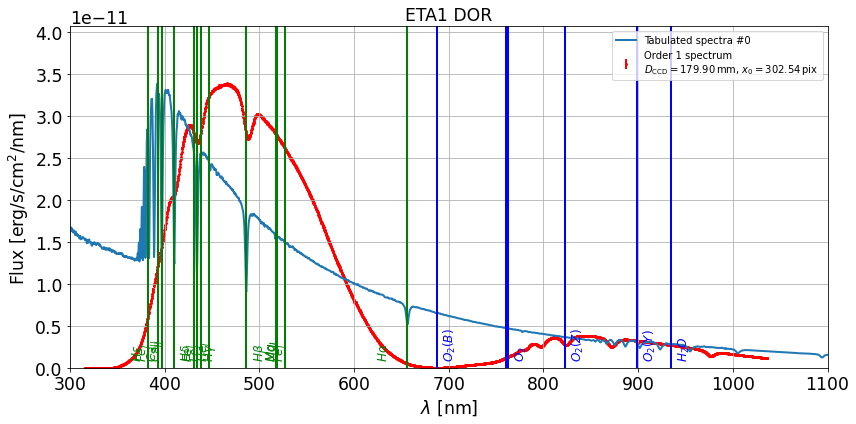

In [41]:
spectrum.plot_spectrum(xlim=[300,1100], live_fit=False, force_lines=True)

- $S_\lambda(\lambda)$ : SED in erg/cm2/s/nm
- FLAM to ADU
$$
\frac{dN_{ADU}(\lambda)}{dN_{pix}} = \left( \frac{S \Delta T \epsilon_{eq}(\lambda)}{G_{el}} \right) \frac{1}{hc} \lambda \frac{d\lambda}{dN_{pix}} \cdot S_\lambda(\lambda)
$$

- ADU to FLAM

$$
S_\lambda(\lambda) = \frac{dn_\gamma(\lambda)}{d\lambda} = \frac{G_{el}}{S\Delta T \epsilon_{QE}(\lambda)} (hc) \frac{1}{\lambda} \left( \frac{dN_{pix}}{d\lambda}\right) \left(\frac{dN_{ADU}}{dN_{pix}} \right)
$$


- FLAM to ADU constant:
$$
FLAM\_TO\_ADURATE = \left( \frac{S}{G_{el}} \right) \frac{1}{hc} \times \left[ TIME \right ]_{unit}  \times \left[ \lambda d\lambda \right]_{unit}
\times \left[ SED \right ]_{unit} 
$$

# Disperser

In [42]:
spectrum.x0

[302.5372179266658, 1754.496653072347]

In [43]:
spectrum.order

1

In [44]:
spectrum.disperser.full_name

'Phase hologram #4-003'

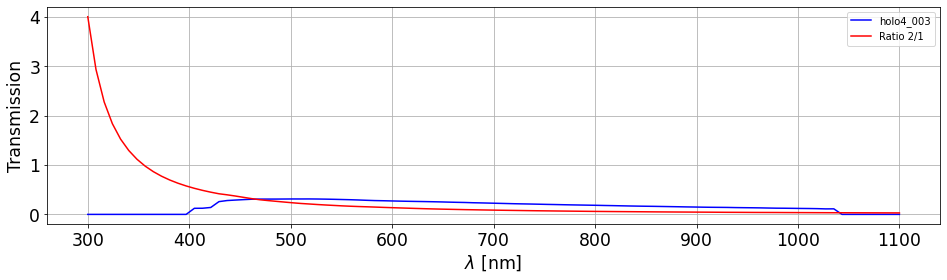

In [45]:
spectrum.disperser.plot_transmission()

In [46]:
spectrum.disperser.N([2000.,300.])

156

In [47]:
spectrum.disperser.load_specs()

In [48]:
my_distance=np.arange(1,3000)

In [49]:
my_lambdas = spectrum.disperser.grating_pixel_to_lambda(my_distance, spectrum.x0, order=spectrum.order)

Text(0.5, 1.0, 'wavelength calib in Spectractor in Spectrum')

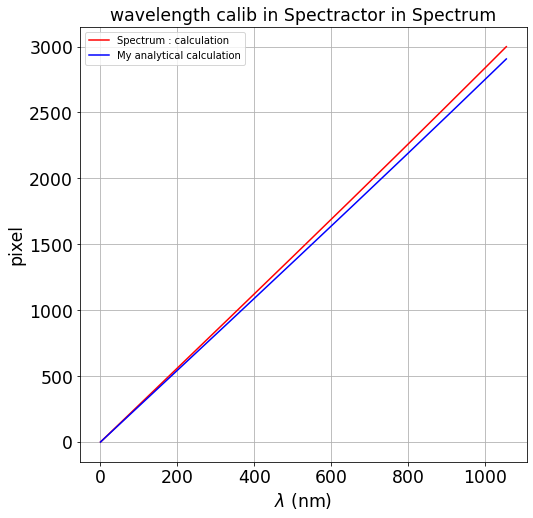

In [51]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(my_lambdas,my_distance,'r-',label="Spectrum : calculation")
x_pix = Dispersion(my_lambdas*1e-6,neff,DCCD)/PIXELW   # pixel per nm
ax.plot(my_lambdas,x_pix,'b-',label="My analytical calculation")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("pixel")
ax.grid()
ax.legend()
ax.set_title("wavelength calib in Spectractor in Spectrum")

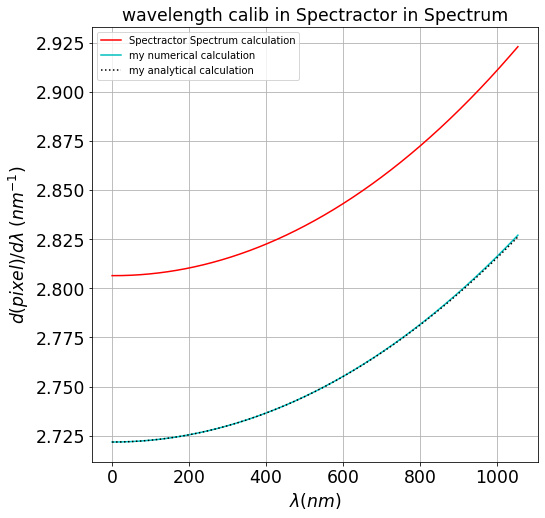

In [52]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(my_lambdas,np.gradient(my_distance,my_lambdas),'r-',label="Spectractor Spectrum calculation")
ax.plot(my_lambdas,np.gradient(x_pix,my_lambdas),'c-',label="my numerical calculation")
ax.plot(my_lambdas,Dispersion_Rate(my_lambdas*1e-6,neff,DCCD)/PIXELW*1e-6,"k:",label="my analytical calculation") 
ax.set_ylabel("$d(pixel)/d\lambda \; (nm^{-1})$")
ax.set_xlabel("$\lambda (nm)$")
ax.grid()
ax.set_title("wavelength calib in Spectractor in Spectrum")
ax.legend()

# Work with table

In [53]:
WLCUT = 670

Text(0.5, 1.0, 'Table : wavelength calib in Spectractor')

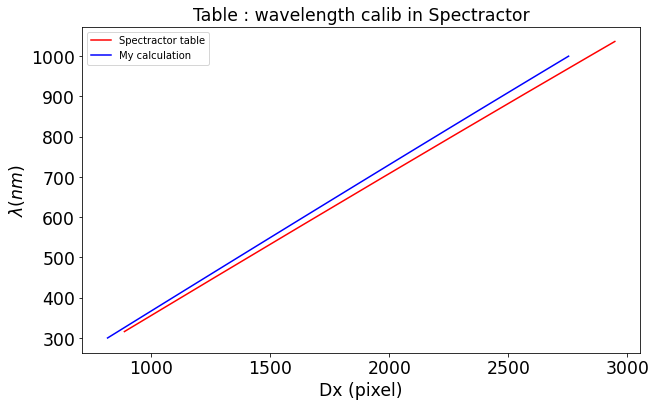

In [54]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(table.Dx,table.lambdas,"r-",label="Spectractor table")
ax.plot(Y1,WL,"b-",label="My calculation")
ax.set_xlabel("Dx (pixel)")
ax.set_ylabel("$\lambda (nm)$")
ax.legend()
ax.set_title("Table : wavelength calib in Spectractor")

Text(0.5, 1.0, 'wavelength calib in Spectractor table')

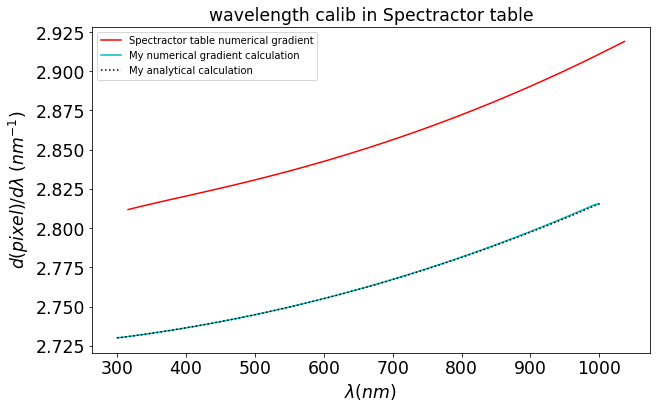

In [55]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(table.lambdas,np.gradient(table.Dx,table.lambdas),"r-",label="Spectractor table numerical gradient")
ax.plot(WL,np.gradient(Y1,WL),"c-",label="My numerical gradient calculation")
ax.plot(WL, Y2,"k:",label="My analytical calculation")
ax.set_ylabel("$d(pixel)/d\lambda \; (nm^{-1})$")
ax.set_xlabel("$\lambda (nm)$")
ax.legend()
ax.set_title("wavelength calib in Spectractor table")

## Spectrum from Table

Text(0.5, 1.0, 'Spectrom from Spectractor Table')

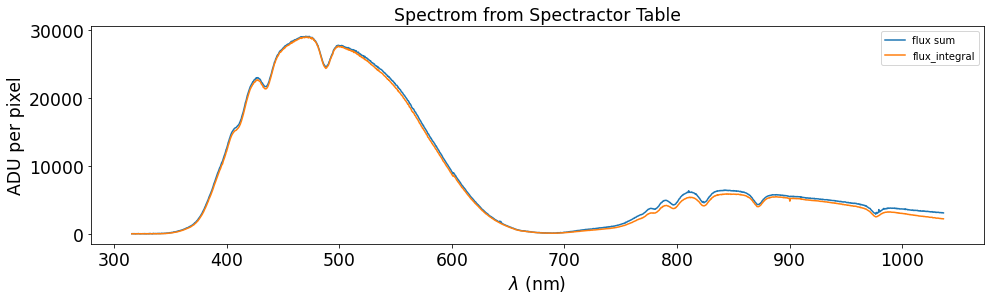

In [67]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(table.lambdas,table.flux_sum,label="flux sum")
ax.plot(table.lambdas,table.flux_integral,label="flux_integral")
ax.legend()
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("ADU per pixel")
ax.set_title("Spectrom from Spectractor Table")

## Extract order 2 and order 1 in Blue filter

In [62]:
order1_idx_t = np.where(table.lambdas.values<WLCUT)
order2_idx_t = np.where(table.lambdas.values>WLCUT)

In [63]:
wl1_t = table.lambdas.values[order1_idx_t] 
flux1_t= table.flux_sum.values[order1_idx_t] 

- order 2 is dispersed with $p=2$, then $\lambda \rightarrow \lambda_{position}/2$
- light for order 2 is dispersed on  twice pixel size

In [82]:
wl2_t = table.lambdas.values[order2_idx_t]/2.   # double dispersion
flux2_t= table.flux_sum.values[order2_idx_t]*2. 

Text(0.5, 1.0, 'Spectra order 1 and 2  from Spectractor Table')

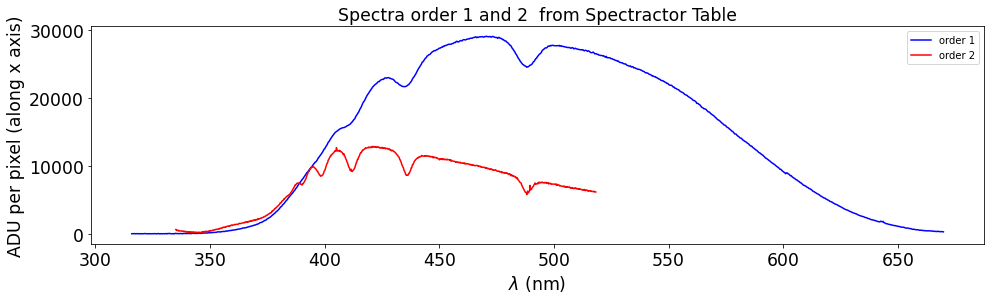

In [66]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(wl1_t,flux1_t,"b",label="order 1")
ax.plot(wl2_t,flux2_t,"r",label="order 2")
ax.legend()
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("ADU per pixel (along x axis)")
ax.set_title("Spectra order 1 and 2  from Spectractor Table")

## Compute ratio from Table

In [68]:
WL=np.arange(350.,520.)

In [69]:
f1_t=np.interp(WL,wl1_t,flux1_t)
f2_t=np.interp(WL,wl2_t,flux2_t)

Text(0.5, 1.0, 'Spectrum ratio order 1 and 2 from Spectractor Table')

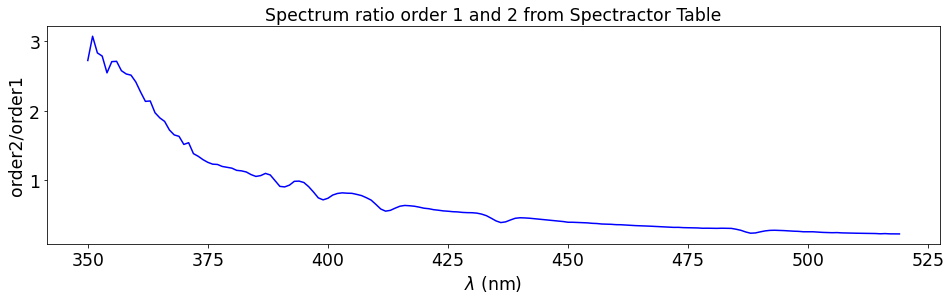

In [78]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(WL,f2_t/f1_t,'b')
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("order2/order1")
ax.set_title("Spectrum ratio order 1 and 2 from Spectractor Table")

## Compute ratio with Spectrum

In [71]:
order1_idx_s = np.where(spectrum.lambdas<WLCUT)
order2_idx_s = np.where(spectrum.lambdas>WLCUT)

In [72]:
wl1_s = spectrum.lambdas[order1_idx_s] 
flux1_s= spectrum.data[order1_idx_s] 

- order 2 is dispersed with $p=2$, then $\lambda \rightarrow \lambda_{position}/2$
- light for order 2 is dispersed on  twice pixel size, and when one convert ADU rate into FLAM we divide the ADU rate by the factor $(p\lambda) d(p \lambda)$

In [80]:
wl2_s = spectrum.lambdas[order2_idx_s]/2. 
flux2_s= spectrum.data[order2_idx_s]*(2**2)

Text(0, 0.5, 'Flux unit')

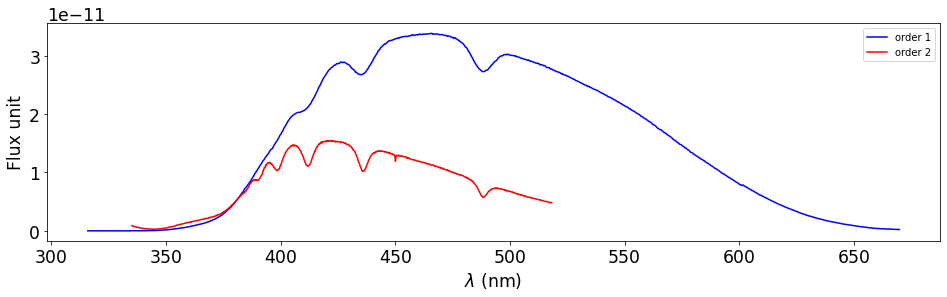

In [81]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(wl1_s,flux1_s,"b",label="order 1")
ax.plot(wl2_s,flux2_s,"r",label="order 2")
ax.legend()
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("Flux unit")

In [75]:
f1_s=np.interp(WL,wl1_s,flux1_s)
f2_s=np.interp(WL,wl2_s,flux2_s)

Text(0.5, 1.0, 'Spectrum ratio order 1 and 2 from Spectractor Table')

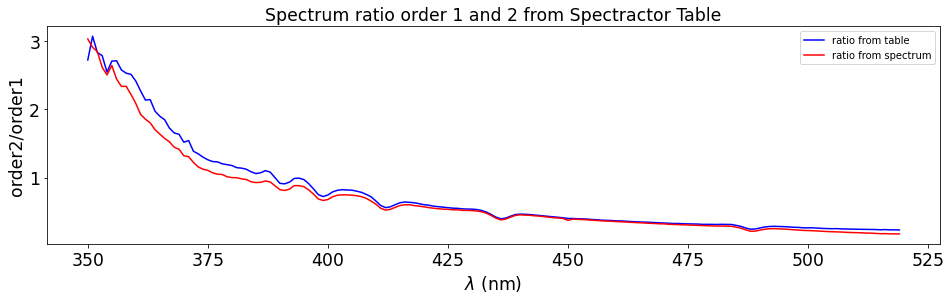

In [79]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(WL,f2_t/f1_t,'b',label="ratio from table")
ax.plot(WL,f2_s/f1_s,'r',label="ratio from spectrum")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("order2/order1")
ax.legend()
ax.set_title("Spectrum ratio order 1 and 2 from Spectractor Table")